In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def filter_contours(contours, min_size, max_size, image, min_influence):
    filtered_contours = []
    image_area = image.shape[0] * image.shape[1]  # Área total de la imagen

    for contour in contours:
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)

        # Calcula la influencia del contorno
        influence = area / image_area

        # Filtra contornos por tamaño, influencia, y posición
        if min_size <= area <= max_size and influence >= min_influence:
            # Si el contorno está muy cerca de los bordes, lo ignora
            if x > 10 and y > 10 and x + w < image.shape[1] - 10 and y + h < image.shape[0] - 10:
                filtered_contours.append(contour)

    return filtered_contours

def segment_contours(contours, image_shape):
    square_contours = []
    rectangular_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        area_ratio = area / (image_shape[0] * image_shape[1])
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h
        if 0.6 <= aspect_ratio <= 1.5 and area_ratio > 0.06:
            square_contours.append(contour)
        else:
            rectangular_contours.append(contour)
    return square_contours, rectangular_contours

def filter_inside_contours(contours):
    filtered_contours = []
    for contour in contours:
        parent_contour = None
        for other_contour in contours:
            if contour is not other_contour:
                if all(cv2.pointPolygonTest(other_contour, (int(pt[0][0]), int(pt[0][1])), False) > 0 for pt in contour):
                    if parent_contour is None or cv2.contourArea(other_contour) > cv2.contourArea(parent_contour):
                        parent_contour = other_contour
        if parent_contour is None:
            filtered_contours.append(contour)
    return filtered_contours

def separate_contours_by_segments(contours, image_width):
    segments = [[] for _ in range(4)]
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        center_x = x + w // 2
        segment = center_x // (image_width // 4)
        segments[segment].append(contour)
    return segments

def order_contours(segments):
    ordered_segments = []
    for segment in segments:
        if len(segment) <= 1:
            ordered_segments.append(segment)
        elif len(segment) == 2:
            x1, y1, w1, h1 = cv2.boundingRect(segment[0])
            x2, y2, w2, h2 = cv2.boundingRect(segment[1])
            if w1 > h1 and w2 > h2:
                ordered_segments.append(sorted(segment, key=lambda c: cv2.boundingRect(c)[1]))
            elif w1 < h1 and w2 < h2:
                ordered_segments.append(sorted(segment, key=lambda c: cv2.boundingRect(c)[0]))
    return ordered_segments

def get_area_ratio(contours, image):
    image_area = (image.shape[0] * image.shape[1]) / 4
    return [round(cv2.contourArea(contour) / image_area, 3) for contour in contours]

# Decode segment number given the information of the segments
def decode_number(segment_info):
    segment_number = ''
    for i in range(4):
        # Validar si el segmento tiene la estructura esperada
        if i >= len(segment_info):
            segment_number += 'X'
            continue
        
        num_contours = segment_info[i]['num_contours']
        orientation = segment_info[i]['orientation']
        area_ratios = segment_info[i]['area_ratios']
        area_ratios_relation = segment_info[i]['area_ratios_relation']
        if num_contours == 0:
            segment_number += '0'
        elif num_contours == 1:
            if orientation[0] == 'horizontal':
                segment_number += '8'
            else:
                if area_ratios[0] < 0.15:
                    segment_number += '1'
                else:
                    segment_number += '5'
        elif num_contours == 2:
            if orientation[0] == 'horizontal':
                if area_ratios_relation > 1.2:
                    segment_number += '7'
                elif area_ratios_relation < 0.8:
                    segment_number += '9'
                else:
                    segment_number += '3'
            else:
                if area_ratios_relation > 1.2:
                    segment_number += '6'
                elif area_ratios_relation < 0.8:
                    segment_number += '4'
                else:
                    segment_number += '2'
        else:
            segment_number += 'X'
    return segment_number

def process_image(image_path):
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_blur = cv2.GaussianBlur(image_gray, (11, 11), 0)
    image_thresh = cv2.adaptiveThreshold(image_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    image_eroded = cv2.erode(image_thresh, np.ones((3, 3), np.uint8), iterations=1)
    contours, _ = cv2.findContours(image_eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filter and segment contours
    filtered_contours = filter_contours(contours, 200, 25000, image_eroded, 0.01)
    _, rectangular_contours = segment_contours(filtered_contours, image_eroded.shape)
    rectangular_contours = filter_inside_contours(rectangular_contours)

    # Separate and process segments
    segments = separate_contours_by_segments(rectangular_contours, image.shape[1])
    ordered_segments = order_contours(segments)

    # Extract segment info
    segment_info = []
    for segment in ordered_segments:
        num_contours = len(segment)
        orientations = ['horizontal' if cv2.boundingRect(c)[2] > cv2.boundingRect(c)[3] else 'vertical' for c in segment]
        area_ratios = get_area_ratio(segment, image)
        if len(segment) == 2:
            area_ratio_relation = round(cv2.contourArea(segment[0]) / cv2.contourArea(segment[1]), 3)
        else:
            area_ratio_relation = None
        segment_info.append({
            'num_contours': num_contours,
            'orientation': orientations,
            'area_ratios': area_ratios,
            'area_ratios_relation': area_ratio_relation
        })

    return decode_number(segment_info)


### Matriz de confusión

Imágenes mal predichas:
Archivo: 0532.jpg, Posición: 4, Real: 2, Predicción: 6
Archivo: 1294 (2).jpg, Posición: 2, Real: 2, Predicción: 3
Archivo: 1294 (3).jpg, Posición: 2, Real: 2, Predicción: 3
Archivo: 1294 (4).jpg, Posición: 2, Real: 2, Predicción: 3
Archivo: 1294.jpg, Posición: 2, Real: 2, Predicción: 3
Archivo: 1910 (2).jpg, Posición: 2, Real: 9, Predicción: 8
Archivo: 1910 (2).jpg, Posición: 3, Real: 1, Predicción: 0
Archivo: 1910 (3).jpg, Posición: 2, Real: 9, Predicción: 0
Archivo: 1910 (3).jpg, Posición: 3, Real: 1, Predicción: 8
Archivo: 1910 (4).jpg, Posición: 2, Real: 9, Predicción: 8
Archivo: 1910 (4).jpg, Posición: 3, Real: 1, Predicción: 0
Archivo: 1910.jpg, Posición: 2, Real: 9, Predicción: 0
Archivo: 1910.jpg, Posición: 3, Real: 1, Predicción: 8
Archivo: 2054.jpg, Posición: 1, Real: 2, Predicción: 6
Archivo: 2317.jpg, Posición: 1, Real: 2, Predicción: 3
Archivo: 2317.jpg, Posición: 2, Real: 3, Predicción: 1
Archivo: 2317.jpg, Posición: 3, Real: 1, Predicción: 7
Archi

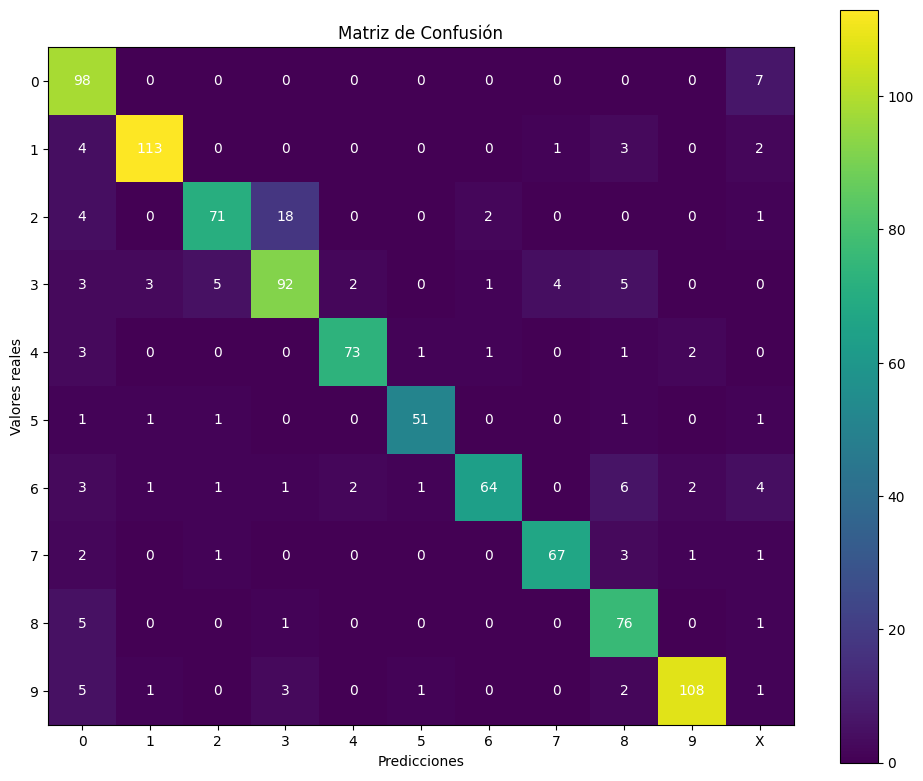

In [2]:
# Inicializar la matriz de confusión con 11 clases (0-9 y X)
num_clases = 11  # Clases 0-9 y "X"
matriz_confusion = np.zeros((10, num_clases), dtype=int)

# Lista para almacenar las imágenes mal predichas
imagenes_mal_predichas = []

# Procesar las imágenes en el directorio
folder_path = "Processed Images"
# Ruta de la carpeta de destino para las imágenes mal predichas
carpeta_destino = "ImagenesProblematicas"
os.makedirs(carpeta_destino, exist_ok=True)  # Crear la carpeta si no existe

archivos = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))]

for file_name in archivos:
    # Leer la imagen
    image_path = os.path.join(folder_path, file_name)
    image = cv2.imread(image_path)

    # Extraer los primeros 4 dígitos del nombre del archivo
    digitos_imagen = file_name[:4]  # Los primeros 4 dígitos del nombre
    digitos_imagen_array = [int(d) for d in digitos_imagen]

    # Predecir los 4 dígitos utilizando tu función `process_image`
    codigo_segmentos = process_image(image_path)

    # Validar que el resultado tenga exactamente 4 caracteres
    if len(codigo_segmentos) < 4:
        codigo_segmentos += "X" * (4 - len(codigo_segmentos))  # Rellenar con 'X' si es necesario
    codigo_segmentos_array = []
    for char in codigo_segmentos:
        if char.isdigit():
            codigo_segmentos_array.append(int(char))
        else:
            codigo_segmentos_array.append(10)  # Asignar 'X' como clase 11

    # Comparar los códigos
    for j in range(4):  # Comparar los 4 dígitos
        fila = digitos_imagen_array[j]
        columna = codigo_segmentos_array[j]
        matriz_confusion[fila, columna] += 1

        # Si no coinciden, agregar el nombre de la imagen y la posición del error
        if fila != columna:
            imagenes_mal_predichas.append({
                "archivo": file_name,
                "posición": j + 1,
                "real": fila,
                "predicción": columna
            })
        
        # Mover la imagen mal predicha a la carpeta "Imagenesproblematicas"
        destino_imagen = os.path.join(carpeta_destino, file_name)
        cv2.imwrite(destino_imagen, image)  # Usar cv2.imwrite() para guardar la imagen


# Mostrar las imágenes mal predichas
print("Imágenes mal predichas:")
for error in imagenes_mal_predichas:
    real_label = str(error["real"]) if error["real"] < 10 else "X"
    pred_label = str(error["predicción"]) if error["predicción"] < 10 else "X"
    print(f"Archivo: {error['archivo']}, Posición: {error['posición']}, Real: {real_label}, Predicción: {pred_label}")

# Crear un heatmap de la matriz de confusión
plt.figure(figsize=(10, 8))
plt.imshow(matriz_confusion, interpolation='nearest', cmap='viridis')
plt.title("Matriz de Confusión")
plt.colorbar()
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")

# Etiquetas de clases
x_labels = [str(i) for i in range(10)] + ["X"]
y_labels = [str(i) for i in range(10)]
plt.xticks(np.arange(num_clases), x_labels)
plt.yticks(np.arange(10), y_labels)

# Mostrar los valores en la matriz
for i in range(10):
    for j in range(num_clases):
        plt.text(j, i, str(matriz_confusion[i, j]), ha='center', va='center', color='white')

plt.tight_layout()
plt.show()

### Tasa de acierto del clasificador

In [3]:
# Calcular accuracy
correctos = np.sum(np.diag(matriz_confusion[:, :10]))  # Valores correctos en las primeras 10 columnas
total = np.sum(matriz_confusion)  # Total de predicciones
accuracy = correctos / total if total > 0 else 0

# Calcular el sumatorio de todos los números analizados
total_numeros_analizados = np.sum(matriz_confusion)
aciertos = np.sum(np.diagonal(matriz_confusion))

# Mostrar el sumatorio de los aciertos
print(f"Total de aciertos (diagonal): {aciertos}")

# Mostrar el sumatorio
print(f"Total de números analizados: {total_numeros_analizados}")

# Mostrar accuracy
print(f"Tasa de acierto del clasificador: {accuracy * 100:.2f}%")

Total de aciertos (diagonal): 813
Total de números analizados: 940
Tasa de acierto del clasificador: 86.49%


### Confusiones

In [4]:
# Función para obtener las confusiones más frecuentes
def obtener_confusiones(matriz_confusion):
    confusiones = []
    for i in range(matriz_confusion.shape[0]):  # Recorrer filas (valores reales)
        for j in range(matriz_confusion.shape[1]):  # Recorrer columnas (predicciones)
            if i != j and matriz_confusion[i, j] > 0:  # Evitar la diagonal principal
                confusiones.append(((i, j), matriz_confusion[i, j]))
    
    # Ordenar por la cantidad de confusiones en orden descendente
    confusiones.sort(key=lambda x: x[1], reverse=True)
    return confusiones

# Obtener las confusiones más frecuentes
confusiones_mas_frecuentes = obtener_confusiones(matriz_confusion)

# Imprimir las confusiones
print("Confusiones más frecuentes:")
for (real, pred), cantidad in confusiones_mas_frecuentes:
    real_label = str(real) if real < 10 else "X"
    pred_label = str(pred) if pred < 10 else "X"
    print(f"Real: {real_label}, Predicción: {pred_label}, Cantidad: {cantidad}")

Confusiones más frecuentes:
Real: 2, Predicción: 3, Cantidad: 18
Real: 0, Predicción: X, Cantidad: 7
Real: 6, Predicción: 8, Cantidad: 6
Real: 3, Predicción: 2, Cantidad: 5
Real: 3, Predicción: 8, Cantidad: 5
Real: 8, Predicción: 0, Cantidad: 5
Real: 9, Predicción: 0, Cantidad: 5
Real: 1, Predicción: 0, Cantidad: 4
Real: 2, Predicción: 0, Cantidad: 4
Real: 3, Predicción: 7, Cantidad: 4
Real: 6, Predicción: X, Cantidad: 4
Real: 1, Predicción: 8, Cantidad: 3
Real: 3, Predicción: 0, Cantidad: 3
Real: 3, Predicción: 1, Cantidad: 3
Real: 4, Predicción: 0, Cantidad: 3
Real: 6, Predicción: 0, Cantidad: 3
Real: 7, Predicción: 8, Cantidad: 3
Real: 9, Predicción: 3, Cantidad: 3
Real: 1, Predicción: X, Cantidad: 2
Real: 2, Predicción: 6, Cantidad: 2
Real: 3, Predicción: 4, Cantidad: 2
Real: 4, Predicción: 9, Cantidad: 2
Real: 6, Predicción: 4, Cantidad: 2
Real: 6, Predicción: 9, Cantidad: 2
Real: 7, Predicción: 0, Cantidad: 2
Real: 9, Predicción: 8, Cantidad: 2
Real: 1, Predicción: 7, Cantidad: 1

### Diagrama de dispersión

C:\Users\paufe\AppData\Local\Temp\ipykernel_10736\2473385813.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colores = plt.cm.get_cmap('tab10', num_clases)  # Usamos un cmap con 11 colores diferentes


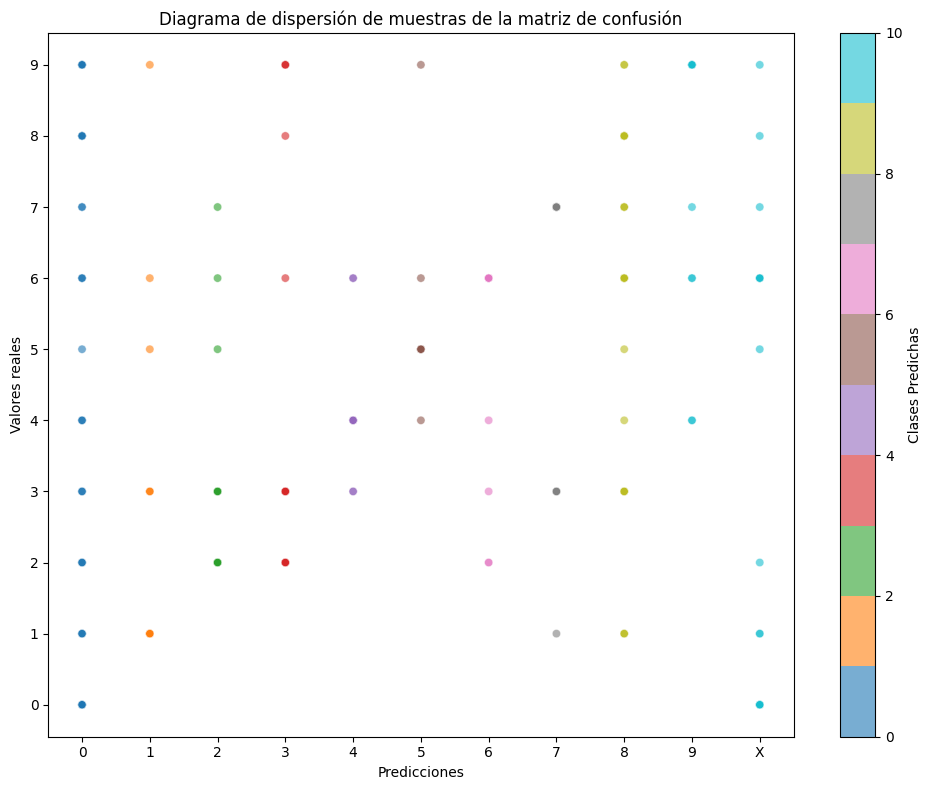

In [5]:

# Inicializamos los colores de cada clase (0-9 y "X")
colores = plt.cm.get_cmap('tab10', num_clases)  # Usamos un cmap con 11 colores diferentes

# Crear listas para las coordenadas y clases de las muestras
x = []  # predicción
y = []  # valor real
clases = []  # clases (0-9 y X)

# Recorrer la matriz de confusión y extraer las posiciones y las clases
for i in range(10):  # Clases reales
    for j in range(num_clases):  # Clases predichas
        count = matriz_confusion[i, j]
        for _ in range(count):  # Repetir el número de veces que aparece el valor
            x.append(j)  # Columna: clase predicha
            y.append(i)  # Fila: clase real
            clases.append(j)  # Clase predicha

# Crear el diagrama de dispersión
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x, y, c=clases, cmap='tab10', alpha=0.6, edgecolors="w", linewidth=0.5)

# Etiquetas
plt.title("Diagrama de dispersión de muestras de la matriz de confusión")
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")

# Etiquetas de las clases en los ejes
x_labels = [str(i) for i in range(10)] + ["X"]
y_labels = [str(i) for i in range(10)]
plt.xticks(np.arange(11), x_labels)
plt.yticks(np.arange(10), y_labels)

# Agregar colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Clases Predichas')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### Diagrama de carga